#Загрузка датасета

In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file = drive.CreateFile({'id': "1CTY-caxh-aF0PkmY0Olbn4f1ZAq7wHH7"})
file.GetContentFile("augmentDataset.zip")
!unzip -uq "augmentDataset.zip" -d ""

file = drive.CreateFile({'id': "1ONZp-J6nLXr4Ovf3NynmYnwUvN6h3b15"})
file.GetContentFile("centeredDataset.zip")
!unzip -uq "centeredDataset.zip" -d ""
!ls

adc.json	    centeredDataset.zip  uniondatasetAugment
augmentDataset.zip  sample_data		 uniondatasetCentered


#Параметры

In [0]:
import random
RANDOM_SEED = 87118956 #random.randint(0, 99999999)

DATASET_NAME = "[Dynamic Hand Gesture 14/28 dataset](http://www-rech.telecom-lille.fr/DHGdataset/) + [SHREC’17 Track Dataset](http://www-rech.telecom-lille.fr/shrec2017-hand/) координаты костей в пространстве + агуметация"
DATASET_AUG_ROOT = "uniondatasetAugment/"
DATASET_CENTERED_ROOT = "uniondatasetCentered/"
COUNT_GUESTURE = 14
COUNT_SAMPLES = 10000
COUNT_AUG_EPOCH = 5

PAD = -1

DROPOUT_X = 0.8
DROPOUT_MASK = 0.8

EXPEREMENT_NAME = 'experement'
EXPEREMENT_PATH = './%s/'%EXPEREMENT_NAME
EPOCH_COUNT = 3
EPOCH_SIZE = 128
LEARN_RATE = 1.0


ZIP_NAME = '%s.zip'%EXPEREMENT_NAME

In [0]:
from zipfile import ZipFile
import os
from shutil import copyfile

import matplotlib.pyplot as plt

def GetFileNameFromTitle(title):
    fileName = title.replace(" ", "_")
    fileName = fileName.lower()
    return fileName

def CreateGraphis(plotsData, countClassesTrain, countClassesTest, directory):
    '''
    plotsData - [(title, [x_label, y_label], [(line_name, [coords])])]
    '''
    for plotData in plotsData:
        fig, ax0 = plt.subplots()
        fig.set_size_inches((10, 8))
        dataLine = list(zip(*plotData[2]))
        for loss in dataLine[1]:
            ax0.plot(loss)
        ax0.legend(dataLine[0], loc='upper left')
        ax0.set_title(plotData[0])
        ax0.set_ylabel(plotData[1][1])
        ax0.set_xlabel(plotData[1][0])
        ax0.grid(True)
        plt.savefig(directory + f'/{GetFileNameFromTitle(plotData[0])}.png')
        plt.show()
    
    # Количество примеров в каждом классе
    fig, (ax0, ax1) = plt.subplots(nrows=2)
    fig.set_size_inches((10, 10))
    fig.suptitle("Распределение классов")
    ax0.bar(range(COUNT_GUESTURE), countClassesTrain)
    ax0.set_xlabel('Номер класса')
    ax0.set_ylabel('Количество примеров')
    ax0.set_title('Тренеровочной выборка')
    ax0.grid(True)
    
    ax1.bar(range(COUNT_GUESTURE), countClassesTest)
    ax1.set_xlabel('Номер класса')
    ax1.set_ylabel('Количество примеров')
    ax1.set_title('Тестовая выборка')
    ax1.grid(True)
    
    plt.savefig(directory + '/classesCount.png')
    plt.show()

def OutputResults(plotsData, countClassesTrain, countClassesTest, 
                  nameModel,
                  trainSize, testSize):
    import shutil
    directory = EXPEREMENT_PATH + nameModel + "/"
    shutil.rmtree(directory, ignore_errors=True)
    os.makedirs(directory)
    
    
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    
    CreateGraphis(plotsData, countClassesTrain, countClassesTest, directory)
    
    # Create README
    readmeText = "# %s\n"%nameModel
    readmeText += "| Кол-во жестов | Обучающая выборка | Тестовая выборка | Количество эпох | Размер эпохи | Random seed | Dataset |\n"
    readmeText += "| ------------- | ----------------- | ---------------- | --------------- | ------------ | ----------- | ------- |\n"
    readmeText += "| %i | %i | %i | %i | %i | %i | %s |\n\n"%(COUNT_GUESTURE, 
                                                              trainSize, 
                                                              testSize,
                                                              EPOCH_COUNT,
                                                              EPOCH_SIZE,
                                                              RANDOM_SEED,
                                                              DATASET_NAME)
    readmeText += "![](classesCount.png)\n"
    readmeText += "## Результаты\n"
    
    for plotData in plotsData:
        readmeText += f"### {plotData[0]}\n"
        readmeText += f"![]({GetFileNameFromTitle(plotData[0])}.png)\n"

    with open(directory + "README.md", "w") as readmeFile:
        readmeFile.write(readmeText)
    
    copyfile(DATASET_AUG_ROOT + "settings.json", directory + "augSettings.json")
    copyfile(DATASET_CENTERED_ROOT + "settings.json", directory + "centeredSettings.json")

    file = drive.CreateFile({'id': "1QbXAs9Rps7_y5oCE6No2aiEAJMVuzDst"})
    file.GetContentFile(directory + "notebook.ipynb")

    with ZipFile(nameModel+"_"+ZIP_NAME, 'w') as z:
        for root, dirs, files in os.walk(directory):
            for file in files:
                z.write(os.path.join(root,file))
            
    file = drive.CreateFile()
    file.SetContentFile(nameModel+"_"+ZIP_NAME)
    file.Upload()

#Иницилизация датасета

In [4]:
import pandas as pd
import numpy as np
import random
import os
import torch

from torch import Tensor

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

columns = []
for i in range(22):
    columns.append("x"+str(i))
    columns.append("y"+str(i))
    columns.append("z"+str(i))
    
MAX_LEN_SEQ = 0
    
trainDatasetX = []
trainDatasetY = []
testDatasetX = []
testDatasetY = []

countClassesPFTrain = np.zeros(COUNT_GUESTURE)
countClassesPFTest = np.zeros(COUNT_GUESTURE)
countClassesTrain = np.zeros(COUNT_GUESTURE)
countClassesTest = np.zeros(COUNT_GUESTURE)

def parseData( path ):
    global MAX_LEN_SEQ
    rawData = pd.read_csv (path, sep=",")
    data = np.array(rawData)
    data = data[1:,:]
    MAX_LEN_SEQ = max(MAX_LEN_SEQ, data.shape[0])
    return data

def addTag(gestureId, shape, isTrain):
    tag = np.full(shape, guestureId)
    if isTrain:
        trainDatasetY.append(tag)
        countClassesPFTrain[gestureId] += shape
        countClassesTrain[gestureId] += 1
    else:
        testDatasetY.append(tag)
        countClassesPFTest[gestureId] += shape
        countClassesTest[gestureId] += 1

for guestureId in range(COUNT_GUESTURE):
    for sampleId in range(COUNT_SAMPLES):
        path = DATASET_CENTERED_ROOT + "gesture_%i/aug_%i_0.csv"%(guestureId, sampleId)
        if not os.path.exists(path):
            break;
        data = parseData(path)
        if random.random() > 0.3:
            trainDatasetX.append (data)
            addTag(guestureId, (data.shape[0],), True)
            for augEpoch in range(COUNT_AUG_EPOCH):
                path = DATASET_AUG_ROOT + "gesture_%i/aug_%i_%i.csv"%(guestureId, sampleId, augEpoch)
                data = parseData(path)
                trainDatasetX.append (data)
                addTag(guestureId, (data.shape[0],), True)
        else:
            testDatasetX.append (data)
            addTag(guestureId, (data.shape[0],), False)
            
print("Размер обучающей выборки: %i"%len(trainDatasetX))
print("Размер тестовой выборки: %i"%len(testDatasetX))
print("Максимальная длина последовательности: %i"%MAX_LEN_SEQ)
assert len(trainDatasetX) == len(trainDatasetY)
assert len(testDatasetX) == len(testDatasetY)

Размер обучающей выборки: 23706
Размер тестовой выборки: 1649
Максимальная длина последовательности: 278


#TCN

## Модель

In [34]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: " + device.type)

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
class TCN(nn.Module):

    def __init__(self, input_size, output_size, num_channels,
                 kernel_size=2, dropout=0.3):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout)

        self.decoder = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.normal_(0, 0.01)

    def forward(self, input):
        """Input ought to have dimension (N, C_in, L_in), where L_in is the seq_len; here the input is (N, L, C)"""
        y = self.tcn(input.transpose(1, 2)).transpose(1, 2)
        y = self.decoder(y)
        return y

Device: cuda


## Предобработка данных

In [35]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
from sklearn import preprocessing
from sklearn import pipeline
import spacy
import torch
from sklearn.preprocessing import FunctionTransformer
from torchtext.data import Field, BucketIterator, Dataset, Example, Iterator

vocab = ["Grab.", "Tap.", "Expand.", "Pinch.", "Rotation right.", "Rotation left.", "Swipe Right.", "Swipe Left.", "Swipe Up.", "Swipe Down.", "Swipe X.", "Swipe V.", "Swipe pluse.", "Shake."]

spacy_en = spacy.load('en')

sos = np.ones((1, testDatasetX[0].shape[1]))
eos = np.zeros((1, testDatasetX[0].shape[1]))

def genPad(bigShape, currShape):
    result = np.zeros((bigShape - currShape[0], currShape[1]))
    return result
    

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def preprocessing_bones(bones):
    #print(bones)
    result = np.concatenate((bones, genPad(MAX_LEN_SEQ, bones.shape)))
    return result

fieldTag = Field(tokenize = tokenize_en, 
                 init_token = '<sos>', 
                 eos_token = '<eos>',
                 pad_token = '<pad>',
                 lower = True,
                 batch_first = False,
                 include_lengths = True,
                 fix_length = MAX_LEN_SEQ)

fieldBones = Field( sequential = False,
                    use_vocab = False,
                    preprocessing  = preprocessing_bones,
                    dtype = torch.float)

fieldSizes = Field( sequential = False,
                    use_vocab = False,
                    dtype = torch.int)
# prepare train data
tags = [vocab[y[0]] for y in trainDatasetY]
lenghts = [d.shape[0] + 2 for d in trainDatasetX]
examples = [Example.fromlist(d, (("src", fieldBones), ("lenghts", fieldSizes), ("trg", fieldTag))) for d in zip(trainDatasetX, lenghts, tags)]
preprocessedTrainDataset = Dataset(examples, (("src", fieldBones), ("lenghts", fieldSizes), ("trg", fieldTag)))


fieldTag.build_vocab(preprocessedTrainDataset, min_freq = 1)

iteratorTrainData = BucketIterator(preprocessedTrainDataset, shuffle = True, batch_size = EPOCH_SIZE, device=device)

# prepare test data
tags = [vocab[y[0]] for y in testDatasetY]
lenghts = [d.shape[0] + 2 for d in testDatasetX]
examples = [Example.fromlist(d, (("src", fieldBones), ("lenghts", fieldSizes), ("trg", fieldTag))) for d in zip(testDatasetX, lenghts, tags)]
preprocessedTestDataset = Dataset(examples, (("src", fieldBones), ("lenghts", fieldSizes), ("trg", fieldTag)))

iteratorTestData = BucketIterator(preprocessedTestDataset, batch_size = EPOCH_SIZE, device=device)


## Обучение

### Train (encoder, decoder, encoder_optimizer, decoder_optimizer, iterator, criterion, clip)

In [0]:
teacher_forcing_ratio = 0.5

def train(model, optimizer, scheduler, iterator, criterion, clip):
    
    loss_result = 0
    acc_result = 0
    
    isStart = True
    
    historyBatchsLoss = []
    historyBatchsAcc = []
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        predictY = model(src)
        predictY = predictY.view(-1, predictY.size(2))
        trgY = trg[0].view(-1)
        
        epoch_loss = criterion(predictY, trgY)
        
        epoch_loss.backward()
        
        predictY = torch.argmax(predictY, 1) == trgY
        acc = predictY.sum().item() / trg[1].sum().item()
        
        
        historyBatchsLoss.append(epoch_loss.item())
        historyBatchsAcc.append(acc)
        
        loss_result += historyBatchsLoss[-1]
        acc_result += historyBatchsAcc[-1]
        
        if(not isStart):
            loss_result /= 2
            acc_result /= 2
        
        isStart = False
        
        optimizer.step()
        
        #scheduler.step(historyBatchsLoss[-1])
        
        print("Batch %i complite '%i'Loss: %f Acc: %f"%(i, len(iterator), loss_result, acc_result))
        
    return loss_result, acc_result, historyBatchsLoss, historyBatchsAcc

### Evaluate

In [0]:

def evaluate(model,iterator, criterion):
    
    loss_result = 0
    acc_result = 0
    
    isStart = True
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
        
            src = batch.src
            trg = batch.trg
        
            predictY = model(src)
            predictY = predictY.view(-1, predictY.size(2))
            trgY = trg[0].view(-1)
        
            epoch_loss = criterion(predictY, trgY)
        
            predictY = torch.argmax(predictY, 1) == trgY
            acc_result = predictY.sum().item() / trg[1].sum().item()
            
            loss_result += epoch_loss.item()
        
            if(not isStart):
                loss_result /= 2
                acc_result /= 2
        
            isStart = False
        
    return loss_result, acc_result

### Process

Batch 0 complite '186'Loss: 2.944916 Acc: 0.086116
Batch 1 complite '186'Loss: 2.681332 Acc: 0.153391
Batch 2 complite '186'Loss: 2.595360 Acc: 0.166642
Batch 3 complite '186'Loss: 2.440264 Acc: 0.193666
Batch 4 complite '186'Loss: 2.398710 Acc: 0.190850
Batch 5 complite '186'Loss: 2.415495 Acc: 0.205391
Batch 6 complite '186'Loss: 2.356524 Acc: 0.196335
Batch 7 complite '186'Loss: 2.307845 Acc: 0.209086
Batch 8 complite '186'Loss: 2.278895 Acc: 0.196851
Batch 9 complite '186'Loss: 2.266591 Acc: 0.210706
Batch 10 complite '186'Loss: 2.249132 Acc: 0.205012
Batch 11 complite '186'Loss: 2.240406 Acc: 0.215580
Batch 12 complite '186'Loss: 2.243439 Acc: 0.218517
Batch 13 complite '186'Loss: 2.230099 Acc: 0.218473
Batch 14 complite '186'Loss: 2.235499 Acc: 0.204392
Batch 15 complite '186'Loss: 2.239009 Acc: 0.213501
Batch 16 complite '186'Loss: 2.234756 Acc: 0.216905
Batch 17 complite '186'Loss: 2.231009 Acc: 0.219757
Batch 18 complite '186'Loss: 2.237550 Acc: 0.221571
Batch 19 complite '186

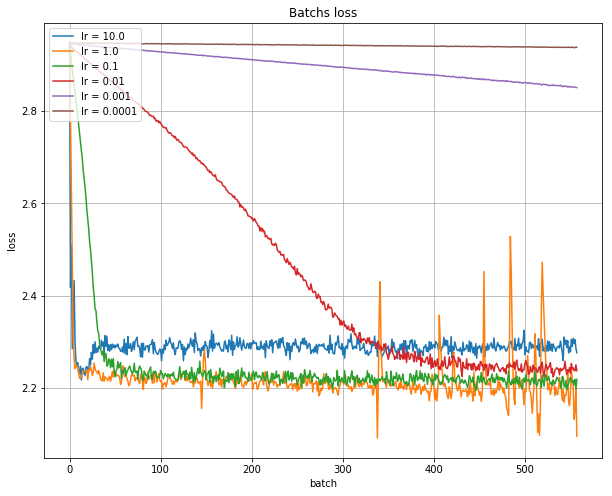

IndexError: ignored

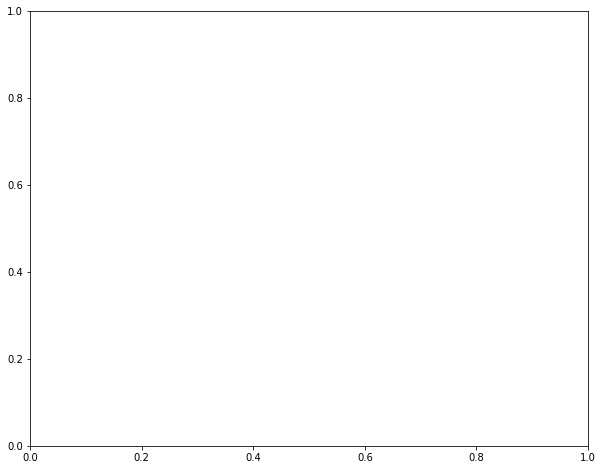

In [40]:
from torch.optim import Adam
from torch.optim import SGD
import time
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

INPUT_DIM = testDatasetX[0].shape[1]
OUTPUT_DIM = len(fieldTag.vocab)
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
DROPOUT = 0.2

model = TCN(66, 19, [64, 128, 256, 512])
model.to(device)

optimizer = SGD(model.parameters(), lr=LEARN_RATE)

scheduler = ReduceLROnPlateau(optimizer, 'min', verbose = True, factor = 0.9)

PAD_IDX = fieldTag.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

CLIP = 1

best_valid_loss = float('inf')

historyAcc = []
historyLoss = []
historyBatchsLoss = []

for lr in [10.0, 1.0, 0.1, 0.01, 0.001, 0.0001]:
    del model
    del optimizer
    model = TCN(66, 19, [64, 128, 256, 512])
    model.to(device)

    optimizer = SGD(model.parameters(), lr=lr)
    
    LRhistoryTrainAcc = []
    LRhistoryTrainLoss = []
    LRhistoryTestAcc = []
    LRhistoryTestLoss = []
    LRhistoryBatchsLoss = []
    
    for epoch in range(EPOCH_COUNT):
    
        start_time = time.time()
    
        train_loss, train_acc, batchsLoss, batchAcc = train(model, optimizer, scheduler, iteratorTrainData, criterion, CLIP)
        valid_loss, valid_acc = evaluate(model, iteratorTestData, criterion)
    
        end_time = time.time()
    
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
        LRhistoryTrainAcc.append(train_acc)
        LRhistoryTrainLoss.append(train_loss)
    
        LRhistoryBatchsLoss = LRhistoryBatchsLoss + batchsLoss
    
        LRhistoryTestAcc.append(valid_acc)
        LRhistoryTestLoss.append(valid_loss)
    
    
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Acc: {train_acc:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} | Acc: {valid_acc:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    historyAcc.append((f"Train lr = {lr}", LRhistoryTrainAcc))
    historyAcc.append((f"Test lr = {lr}", LRhistoryTestAcc))
    
    historyLoss.append((f"Train lr = {lr}", LRhistoryTrainLoss))
    historyLoss.append((f"Test lr = {lr}", LRhistoryTestLoss))
    
    historyBatchsLoss.append((f"lr = {lr}", LRhistoryBatchsLoss))

outPlots = [("Batchs loss", ["batch", "loss"], historyBatchsLoss),
            ("Acc", ["epoch", "acc"], historyAcc),
            ("Loss", ["epoch", "loss"], historyLoss)]
OutputResults(outPlots, countClassesTrain, countClassesTest, "TCN", len(trainDatasetX), len(testDatasetX))

('Batchs loss', ['batch', 'loss'], [('lr = 10.0', [2.944916248321533, 2.4177470207214355, 2.5093886852264404, 2.285167932510376, 2.357156753540039, 2.432278871536255, 2.297553062438965, 2.259166955947876, 2.2499451637268066, 2.254286050796509, 2.231673240661621, 2.231680154800415, 2.246471405029297, 2.216759443283081, 2.240898609161377, 2.242518901824951, 2.2305028438568115, 2.2272613048553467, 2.2440907955169678, 2.2460339069366455, 2.240241527557373, 2.2363357543945312, 2.2629642486572266, 2.2499048709869385, 2.276845693588257, 2.262101411819458, 2.293907403945923, 2.2746057510375977, 2.299670457839966, 2.2766048908233643, 2.2858481407165527, 2.2776665687561035, 2.2902915477752686, 2.2857420444488525, 2.2840945720672607, 2.302936315536499, 2.290447235107422, 2.2995071411132812, 2.2768471240997314, 2.313091278076172, 2.289738655090332, 2.3116774559020996, 2.2810957431793213, 2.2930591106414795, 2.2791528701782227, 2.294102191925049, 2.2827634811401367, 2.2946269512176514, 2.2870717048

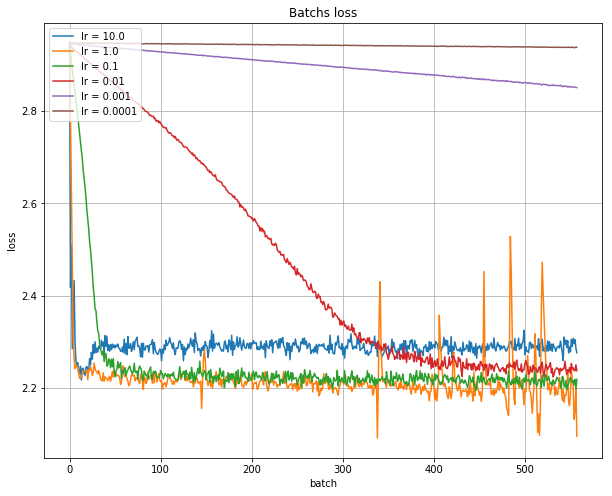

('Acc', ['epoch', 'acc'], [('Train lr = 10.0', [0.2220389396041147, 0.2205053272866452, 0.22106224569695035]), ('Test lr = 10.0', [0.11072664359861592, 0.1103448275862069, 0.11169284467713787]), ('Train lr = 1.0', [0.2268095422885345, 0.24634756834030344, 0.2970847553317393]), ('Test lr = 1.0', [0.1170940170940171, 0.1210801393728223, 0.11591695501730104]), ('Train lr = 0.1', [0.2394630151937993, 0.2311019293167949, 0.22976812780790493]), ('Test lr = 0.1', [0.1099476439790576, 0.11082024432809773, 0.11631944444444445]), ('Train lr = 0.01', [0.21573654394349487, 0.21035077246418254, 0.221046183272882]), ('Test lr = 0.01', [0.1145104895104895, 0.10265486725663717, 0.11599297012302284]), ('Train lr = 0.001', [0.2229495659706374, 0.223874411175838, 0.22022521236060658]), ('Test lr = 0.001', [0.11208406304728546, 0.11072664359861592, 0.11267605633802817]), ('Train lr = 0.0001', [34.64702236834832, 22.440971221082478, 2.6514293300625864]), ('Test lr = 0.0001', [17.577797202797203, 11.2678260

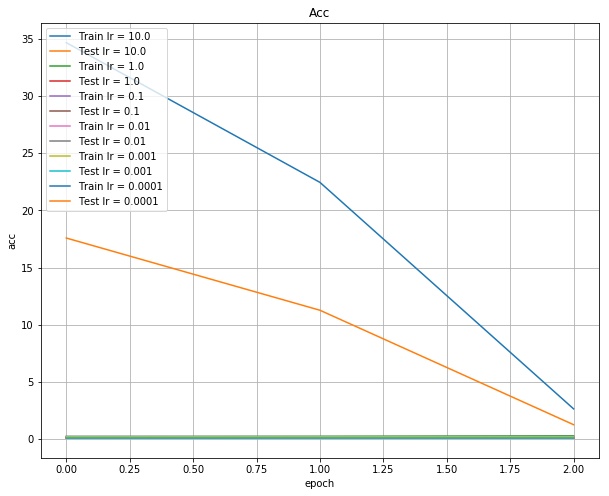

('Loss', ['epoch', 'loss'], [('Train lr = 10.0', [2.2946242464977167, 2.2851265317157448, 2.2846546924494495]), ('Test lr = 10.0', [2.2906438508071005, 2.2757307292777114, 2.2872785140643828]), ('Train lr = 1.0', [2.2103381204381694, 2.2056757172095547, 2.1374606553766275]), ('Test lr = 1.0', [2.2041761414147913, 2.197877681523096, 2.2067753163864836]), ('Train lr = 0.1', [2.2299289763043086, 2.2088321104731046, 2.212088015273573]), ('Test lr = 0.1', [2.228140775929205, 2.212906804983504, 2.2073105053859763]), ('Train lr = 0.01', [2.606046576835011, 2.2698872737012934, 2.2405794596431585]), ('Test lr = 0.01', [2.600581814884208, 2.258471441688016, 2.238573021488264]), ('Train lr = 0.001', [2.9139570623785573, 2.8821489245343965, 2.850965828467189]), ('Test lr = 0.001', [2.9133677062927745, 2.8818919060286134, 2.850895059935283]), ('Train lr = 0.0001', [2.9438816285170293, 2.9410205278175425, 2.937866401696885]), ('Test lr = 0.0001', [2.9443445734214038, 2.9409483302151784, 2.9375089628

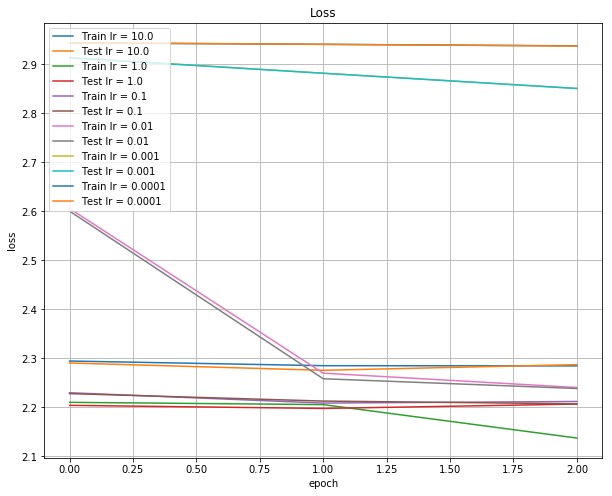

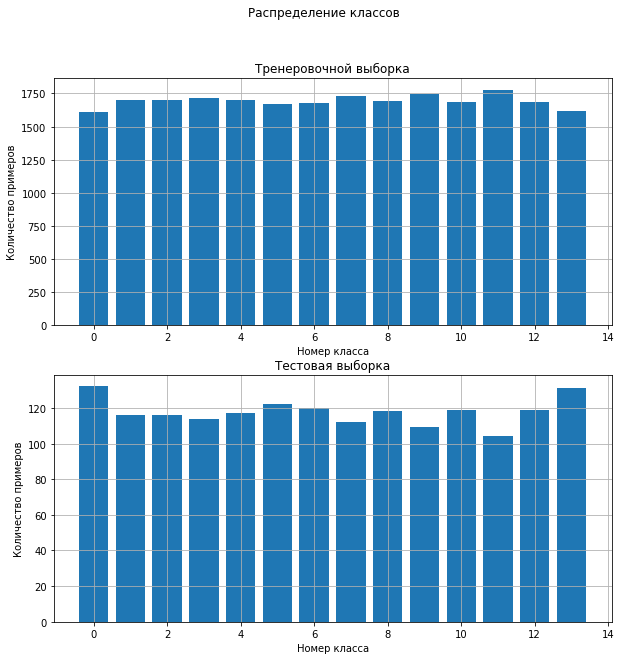

In [43]:
outPlots = [("Batchs loss", ["batch", "loss"], historyBatchsLoss),
            ("Acc", ["epoch", "acc"], historyAcc),
            ("Loss", ["epoch", "loss"], historyLoss)]
OutputResults(outPlots, countClassesTrain, countClassesTest, "TCN", len(trainDatasetX), len(testDatasetX))